<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:04:54] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


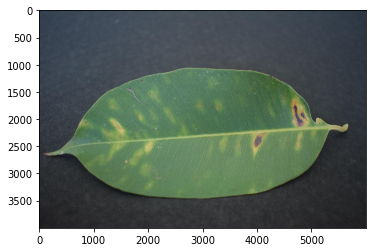

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

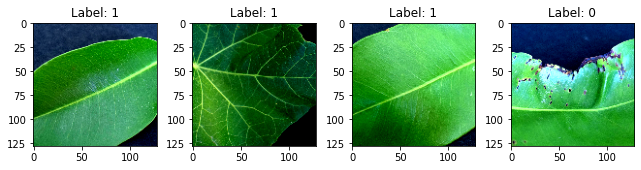

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:05:00] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:05:02] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2309591371877748 samples/sec                   batch loss = 0.8938978314399719 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2673312320949373 samples/sec                   batch loss = 0.5772040486335754 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2674513880442428 samples/sec                   batch loss = 0.6410512328147888 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.2662640415983175 samples/sec                   batch loss = 0.4827318489551544 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.26730251293101 samples/sec                   batch loss = 0.6306602358818054 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.2620784133508227 samples/sec                   batch loss = 0.5999560952186584 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2614279297615416 samples/sec                   batch loss = 0.6448081731796265 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.2573541568146338 samples/sec                   batch loss = 0.7573203444480896 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2619165600854696 samples/sec                   batch loss = 0.8901400566101074 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.2660310810137778 samples/sec                   batch loss = 0.715560257434845 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.2630748433542356 samples/sec                   batch loss = 0.5660198330879211 | accuracy = 0.5909090909090909


Epoch[1] Batch[60] Speed: 1.2634396217004578 samples/sec                   batch loss = 0.33854222297668457 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.269408681230214 samples/sec                   batch loss = 0.6454076766967773 | accuracy = 0.6038461538461538


Epoch[1] Batch[70] Speed: 1.273910747060787 samples/sec                   batch loss = 0.5043653845787048 | accuracy = 0.6142857142857143


Epoch[1] Batch[75] Speed: 1.2638607816927636 samples/sec                   batch loss = 0.6817836761474609 | accuracy = 0.62


Epoch[1] Batch[80] Speed: 1.2718724447458631 samples/sec                   batch loss = 0.7623586058616638 | accuracy = 0.625


Epoch[1] Batch[85] Speed: 1.2757178890802023 samples/sec                   batch loss = 1.029404878616333 | accuracy = 0.6235294117647059


Epoch[1] Batch[90] Speed: 1.2664636264583544 samples/sec                   batch loss = 0.3427780866622925 | accuracy = 0.625


Epoch[1] Batch[95] Speed: 1.2585304151686632 samples/sec                   batch loss = 0.3808605670928955 | accuracy = 0.6289473684210526


Epoch[1] Batch[100] Speed: 1.2632922582272572 samples/sec                   batch loss = 0.7917478680610657 | accuracy = 0.63


Epoch[1] Batch[105] Speed: 1.2697686707592093 samples/sec                   batch loss = 0.48973017930984497 | accuracy = 0.6357142857142857


Epoch[1] Batch[110] Speed: 1.2633722621482142 samples/sec                   batch loss = 0.4911372661590576 | accuracy = 0.6318181818181818


Epoch[1] Batch[115] Speed: 1.2568004147680125 samples/sec                   batch loss = 0.3103325068950653 | accuracy = 0.6413043478260869


Epoch[1] Batch[120] Speed: 1.2674048548301124 samples/sec                   batch loss = 1.9497227668762207 | accuracy = 0.6375


Epoch[1] Batch[125] Speed: 1.2665098993644508 samples/sec                   batch loss = 1.1566872596740723 | accuracy = 0.63


Epoch[1] Batch[130] Speed: 1.2619364928500714 samples/sec                   batch loss = 0.4336404800415039 | accuracy = 0.6346153846153846


Epoch[1] Batch[135] Speed: 1.2655491878698932 samples/sec                   batch loss = 0.6001035571098328 | accuracy = 0.6407407407407407


Epoch[1] Batch[140] Speed: 1.2667188387742196 samples/sec                   batch loss = 0.6326320171356201 | accuracy = 0.6464285714285715


Epoch[1] Batch[145] Speed: 1.2690613748968718 samples/sec                   batch loss = 0.7201390862464905 | accuracy = 0.6482758620689655


Epoch[1] Batch[150] Speed: 1.2678884499244922 samples/sec                   batch loss = 0.5405198931694031 | accuracy = 0.6483333333333333


Epoch[1] Batch[155] Speed: 1.2713927432955678 samples/sec                   batch loss = 0.47737306356430054 | accuracy = 0.6483870967741936


Epoch[1] Batch[160] Speed: 1.26742745077894 samples/sec                   batch loss = 0.7876349091529846 | accuracy = 0.6515625


Epoch[1] Batch[165] Speed: 1.2676256785907225 samples/sec                   batch loss = 0.9845712184906006 | accuracy = 0.6515151515151515


Epoch[1] Batch[170] Speed: 1.2606982511709608 samples/sec                   batch loss = 0.6667175889015198 | accuracy = 0.6544117647058824


Epoch[1] Batch[175] Speed: 1.2632080795486331 samples/sec                   batch loss = 0.6260334253311157 | accuracy = 0.6528571428571428


Epoch[1] Batch[180] Speed: 1.2630993772443873 samples/sec                   batch loss = 1.2148793935775757 | accuracy = 0.6513888888888889


Epoch[1] Batch[185] Speed: 1.2630179816454088 samples/sec                   batch loss = 0.6328147649765015 | accuracy = 0.6513513513513514


Epoch[1] Batch[190] Speed: 1.261597721468196 samples/sec                   batch loss = 0.7224398255348206 | accuracy = 0.6526315789473685


Epoch[1] Batch[195] Speed: 1.2685583723283171 samples/sec                   batch loss = 0.23090462386608124 | accuracy = 0.6564102564102564


Epoch[1] Batch[200] Speed: 1.266645391344749 samples/sec                   batch loss = 0.605408787727356 | accuracy = 0.6575


Epoch[1] Batch[205] Speed: 1.2663431797915456 samples/sec                   batch loss = 0.41119229793548584 | accuracy = 0.6634146341463415


Epoch[1] Batch[210] Speed: 1.2641285664814415 samples/sec                   batch loss = 0.6775882244110107 | accuracy = 0.6630952380952381


Epoch[1] Batch[215] Speed: 1.2656937363866307 samples/sec                   batch loss = 0.4600989520549774 | accuracy = 0.6662790697674419


Epoch[1] Batch[220] Speed: 1.2648043415770596 samples/sec                   batch loss = 0.6792972087860107 | accuracy = 0.6681818181818182


Epoch[1] Batch[225] Speed: 1.2615400440755076 samples/sec                   batch loss = 0.7543302774429321 | accuracy = 0.67


Epoch[1] Batch[230] Speed: 1.261201959532454 samples/sec                   batch loss = 0.4573400914669037 | accuracy = 0.6739130434782609


Epoch[1] Batch[235] Speed: 1.265848059747078 samples/sec                   batch loss = 0.5862656831741333 | accuracy = 0.675531914893617


Epoch[1] Batch[240] Speed: 1.2681770203265517 samples/sec                   batch loss = 0.3743550479412079 | accuracy = 0.6770833333333334


Epoch[1] Batch[245] Speed: 1.2546313149910397 samples/sec                   batch loss = 0.8533125519752502 | accuracy = 0.6755102040816326


Epoch[1] Batch[250] Speed: 1.2645808775250684 samples/sec                   batch loss = 0.585820734500885 | accuracy = 0.676


Epoch[1] Batch[255] Speed: 1.2636927599253438 samples/sec                   batch loss = 0.2665501534938812 | accuracy = 0.6774509803921569


Epoch[1] Batch[260] Speed: 1.2583743785464219 samples/sec                   batch loss = 0.6339765191078186 | accuracy = 0.676923076923077


Epoch[1] Batch[265] Speed: 1.2587351244100013 samples/sec                   batch loss = 0.2426300048828125 | accuracy = 0.6792452830188679


Epoch[1] Batch[270] Speed: 1.2590024419545212 samples/sec                   batch loss = 0.9172918796539307 | accuracy = 0.6805555555555556


Epoch[1] Batch[275] Speed: 1.2653528495489414 samples/sec                   batch loss = 1.6913288831710815 | accuracy = 0.68


Epoch[1] Batch[280] Speed: 1.2641977213839641 samples/sec                   batch loss = 0.5471304059028625 | accuracy = 0.6794642857142857


Epoch[1] Batch[285] Speed: 1.2593263032549604 samples/sec                   batch loss = 0.6693176031112671 | accuracy = 0.6807017543859649


Epoch[1] Batch[290] Speed: 1.2681101132010097 samples/sec                   batch loss = 0.5929223895072937 | accuracy = 0.6810344827586207


Epoch[1] Batch[295] Speed: 1.2641237087768327 samples/sec                   batch loss = 0.5460172295570374 | accuracy = 0.6822033898305084


Epoch[1] Batch[300] Speed: 1.2636156657403383 samples/sec                   batch loss = 1.0929036140441895 | accuracy = 0.68


Epoch[1] Batch[305] Speed: 1.2642484016811417 samples/sec                   batch loss = 0.5947765111923218 | accuracy = 0.6811475409836065


Epoch[1] Batch[310] Speed: 1.265177179836697 samples/sec                   batch loss = 0.2254415601491928 | accuracy = 0.682258064516129


Epoch[1] Batch[315] Speed: 1.272089040992024 samples/sec                   batch loss = 1.2762930393218994 | accuracy = 0.6801587301587302


Epoch[1] Batch[320] Speed: 1.260362889991351 samples/sec                   batch loss = 0.4928535521030426 | accuracy = 0.68359375


Epoch[1] Batch[325] Speed: 1.2574220070376352 samples/sec                   batch loss = 0.13817447423934937 | accuracy = 0.683076923076923


Epoch[1] Batch[330] Speed: 1.2649128607117182 samples/sec                   batch loss = 0.46268150210380554 | accuracy = 0.6795454545454546


Epoch[1] Batch[335] Speed: 1.261710530165037 samples/sec                   batch loss = 0.34017956256866455 | accuracy = 0.682089552238806


Epoch[1] Batch[340] Speed: 1.2618587586288645 samples/sec                   batch loss = 0.3263404965400696 | accuracy = 0.6838235294117647


Epoch[1] Batch[345] Speed: 1.2671178797947562 samples/sec                   batch loss = 0.40959590673446655 | accuracy = 0.686231884057971


Epoch[1] Batch[350] Speed: 1.261006683317022 samples/sec                   batch loss = 0.9820656776428223 | accuracy = 0.6864285714285714


Epoch[1] Batch[355] Speed: 1.262505601511044 samples/sec                   batch loss = 1.1027644872665405 | accuracy = 0.6838028169014084


Epoch[1] Batch[360] Speed: 1.260423395236552 samples/sec                   batch loss = 0.8991055488586426 | accuracy = 0.6833333333333333


Epoch[1] Batch[365] Speed: 1.2625347687379436 samples/sec                   batch loss = 0.6832932829856873 | accuracy = 0.6842465753424658


Epoch[1] Batch[370] Speed: 1.2634472334009668 samples/sec                   batch loss = 0.7563613653182983 | accuracy = 0.6851351351351351


Epoch[1] Batch[375] Speed: 1.26629424293003 samples/sec                   batch loss = 0.6308295130729675 | accuracy = 0.686


Epoch[1] Batch[380] Speed: 1.265476639633672 samples/sec                   batch loss = 0.5622552037239075 | accuracy = 0.6875


Epoch[1] Batch[385] Speed: 1.2720919345845172 samples/sec                   batch loss = 0.40651392936706543 | accuracy = 0.688961038961039


Epoch[1] Batch[390] Speed: 1.2612924137662465 samples/sec                   batch loss = 1.348179578781128 | accuracy = 0.6878205128205128


Epoch[1] Batch[395] Speed: 1.2580608176127746 samples/sec                   batch loss = 0.43261295557022095 | accuracy = 0.6879746835443038


Epoch[1] Batch[400] Speed: 1.2698512271538336 samples/sec                   batch loss = 1.338665246963501 | accuracy = 0.686875


Epoch[1] Batch[405] Speed: 1.2664775844581793 samples/sec                   batch loss = 1.0492925643920898 | accuracy = 0.687037037037037


Epoch[1] Batch[410] Speed: 1.256956343786807 samples/sec                   batch loss = 1.393619179725647 | accuracy = 0.6878048780487804


Epoch[1] Batch[415] Speed: 1.2618985262219844 samples/sec                   batch loss = 0.23946420848369598 | accuracy = 0.6885542168674699


Epoch[1] Batch[420] Speed: 1.2637834766110037 samples/sec                   batch loss = 0.34737807512283325 | accuracy = 0.6916666666666667


Epoch[1] Batch[425] Speed: 1.2641090406404656 samples/sec                   batch loss = 0.4264411926269531 | accuracy = 0.6905882352941176


Epoch[1] Batch[430] Speed: 1.2609182601491076 samples/sec                   batch loss = 0.7428520917892456 | accuracy = 0.6906976744186046


Epoch[1] Batch[435] Speed: 1.2661656105485626 samples/sec                   batch loss = 0.5128244161605835 | accuracy = 0.6885057471264368


Epoch[1] Batch[440] Speed: 1.261804094143197 samples/sec                   batch loss = 0.3819997310638428 | accuracy = 0.6857954545454545


Epoch[1] Batch[445] Speed: 1.265922656494344 samples/sec                   batch loss = 0.2392919361591339 | accuracy = 0.6882022471910112


Epoch[1] Batch[450] Speed: 1.262021831184619 samples/sec                   batch loss = 0.7874413132667542 | accuracy = 0.6866666666666666


Epoch[1] Batch[455] Speed: 1.2669886016294607 samples/sec                   batch loss = 1.2734644412994385 | accuracy = 0.6857142857142857


Epoch[1] Batch[460] Speed: 1.2653340493185068 samples/sec                   batch loss = 0.35725730657577515 | accuracy = 0.6853260869565218


Epoch[1] Batch[465] Speed: 1.2521622414766442 samples/sec                   batch loss = 0.6286599636077881 | accuracy = 0.6849462365591398


Epoch[1] Batch[470] Speed: 1.2675294298079767 samples/sec                   batch loss = 0.6331846714019775 | accuracy = 0.6851063829787234


Epoch[1] Batch[475] Speed: 1.267691097797894 samples/sec                   batch loss = 0.49952033162117004 | accuracy = 0.6842105263157895


Epoch[1] Batch[480] Speed: 1.2594732156128527 samples/sec                   batch loss = 0.7121291160583496 | accuracy = 0.6848958333333334


Epoch[1] Batch[485] Speed: 1.2608535380814276 samples/sec                   batch loss = 0.4377591609954834 | accuracy = 0.6855670103092784


Epoch[1] Batch[490] Speed: 1.2685252814128545 samples/sec                   batch loss = 0.5454215407371521 | accuracy = 0.686734693877551


Epoch[1] Batch[495] Speed: 1.267989832329266 samples/sec                   batch loss = 0.5293325781822205 | accuracy = 0.6858585858585858


Epoch[1] Batch[500] Speed: 1.2624211476635239 samples/sec                   batch loss = 0.4228819012641907 | accuracy = 0.6855


Epoch[1] Batch[505] Speed: 1.2593113681393298 samples/sec                   batch loss = 0.41249629855155945 | accuracy = 0.6861386138613862


Epoch[1] Batch[510] Speed: 1.2643159499727088 samples/sec                   batch loss = 0.37290364503860474 | accuracy = 0.6877450980392157


Epoch[1] Batch[515] Speed: 1.2708354258633836 samples/sec                   batch loss = 0.15639007091522217 | accuracy = 0.6898058252427185


Epoch[1] Batch[520] Speed: 1.2708997327031615 samples/sec                   batch loss = 0.475237101316452 | accuracy = 0.6889423076923077


Epoch[1] Batch[525] Speed: 1.2689973499422578 samples/sec                   batch loss = 0.42479583621025085 | accuracy = 0.6895238095238095


Epoch[1] Batch[530] Speed: 1.266616129507397 samples/sec                   batch loss = 1.0930787324905396 | accuracy = 0.6882075471698114


Epoch[1] Batch[535] Speed: 1.2616684973170431 samples/sec                   batch loss = 0.6733409762382507 | accuracy = 0.6878504672897197


Epoch[1] Batch[540] Speed: 1.2584373360356471 samples/sec                   batch loss = 0.45417529344558716 | accuracy = 0.6875


Epoch[1] Batch[545] Speed: 1.2675199493754048 samples/sec                   batch loss = 0.4208509922027588 | accuracy = 0.6889908256880733


Epoch[1] Batch[550] Speed: 1.2641437113295642 samples/sec                   batch loss = 0.6084985733032227 | accuracy = 0.6890909090909091


Epoch[1] Batch[555] Speed: 1.2612213008566828 samples/sec                   batch loss = 0.7531573176383972 | accuracy = 0.6878378378378378


Epoch[1] Batch[560] Speed: 1.2668084599999638 samples/sec                   batch loss = 0.17152270674705505 | accuracy = 0.6897321428571429


Epoch[1] Batch[565] Speed: 1.26689914624919 samples/sec                   batch loss = 0.35096248984336853 | accuracy = 0.6911504424778762


Epoch[1] Batch[570] Speed: 1.2634740653767302 samples/sec                   batch loss = 0.1764800250530243 | accuracy = 0.6912280701754386


Epoch[1] Batch[575] Speed: 1.262534483709662 samples/sec                   batch loss = 0.622047483921051 | accuracy = 0.6908695652173913


Epoch[1] Batch[580] Speed: 1.253196236709938 samples/sec                   batch loss = 0.5423990488052368 | accuracy = 0.6926724137931034


Epoch[1] Batch[585] Speed: 1.2625165271873644 samples/sec                   batch loss = 0.8194589018821716 | accuracy = 0.6918803418803419


Epoch[1] Batch[590] Speed: 1.259830807734362 samples/sec                   batch loss = 0.28059807419776917 | accuracy = 0.6927966101694916


Epoch[1] Batch[595] Speed: 1.263760248852936 samples/sec                   batch loss = 0.38102012872695923 | accuracy = 0.6936974789915966


Epoch[1] Batch[600] Speed: 1.2659516952495014 samples/sec                   batch loss = 0.3807051479816437 | accuracy = 0.6945833333333333


Epoch[1] Batch[605] Speed: 1.275306918798726 samples/sec                   batch loss = 0.38681188225746155 | accuracy = 0.6958677685950413


Epoch[1] Batch[610] Speed: 1.2689540623668105 samples/sec                   batch loss = 0.3128858208656311 | accuracy = 0.6967213114754098


Epoch[1] Batch[615] Speed: 1.2624058540806442 samples/sec                   batch loss = 1.0798976421356201 | accuracy = 0.6967479674796748


Epoch[1] Batch[620] Speed: 1.269882657147375 samples/sec                   batch loss = 0.6908923387527466 | accuracy = 0.6963709677419355


Epoch[1] Batch[625] Speed: 1.2694712107960187 samples/sec                   batch loss = 0.4513166546821594 | accuracy = 0.6956


Epoch[1] Batch[630] Speed: 1.2715235963987326 samples/sec                   batch loss = 0.5038829445838928 | accuracy = 0.6968253968253968


Epoch[1] Batch[635] Speed: 1.2641833373030857 samples/sec                   batch loss = 1.0811183452606201 | accuracy = 0.6980314960629921


Epoch[1] Batch[640] Speed: 1.2677167692581923 samples/sec                   batch loss = 0.3896552324295044 | accuracy = 0.69765625


Epoch[1] Batch[645] Speed: 1.2677646665531686 samples/sec                   batch loss = 0.25571581721305847 | accuracy = 0.6972868217054263


Epoch[1] Batch[650] Speed: 1.269967343252228 samples/sec                   batch loss = 0.4564877152442932 | accuracy = 0.6984615384615385


Epoch[1] Batch[655] Speed: 1.2623632049903373 samples/sec                   batch loss = 0.49258506298065186 | accuracy = 0.6988549618320611


Epoch[1] Batch[660] Speed: 1.264683066302476 samples/sec                   batch loss = 0.3634144067764282 | accuracy = 0.6996212121212121


Epoch[1] Batch[665] Speed: 1.2652516975323422 samples/sec                   batch loss = 1.032631516456604 | accuracy = 0.6996240601503759


Epoch[1] Batch[670] Speed: 1.2632935899575137 samples/sec                   batch loss = 0.2912231385707855 | accuracy = 0.7


Epoch[1] Batch[675] Speed: 1.2702171417219128 samples/sec                   batch loss = 0.8855829834938049 | accuracy = 0.7


Epoch[1] Batch[680] Speed: 1.2679890656717976 samples/sec                   batch loss = 0.44550058245658875 | accuracy = 0.7003676470588235


Epoch[1] Batch[685] Speed: 1.2700143532408188 samples/sec                   batch loss = 0.23085694015026093 | accuracy = 0.7018248175182482


Epoch[1] Batch[690] Speed: 1.2675364205208157 samples/sec                   batch loss = 0.3435472846031189 | accuracy = 0.7014492753623188


Epoch[1] Batch[695] Speed: 1.2626483152400223 samples/sec                   batch loss = 0.3932643532752991 | accuracy = 0.702158273381295


Epoch[1] Batch[700] Speed: 1.2716922612568178 samples/sec                   batch loss = 0.6203525066375732 | accuracy = 0.7014285714285714


Epoch[1] Batch[705] Speed: 1.2683828663087842 samples/sec                   batch loss = 0.6909067034721375 | accuracy = 0.701418439716312


Epoch[1] Batch[710] Speed: 1.2652330911395004 samples/sec                   batch loss = 0.6784425973892212 | accuracy = 0.7003521126760563


Epoch[1] Batch[715] Speed: 1.267662170756437 samples/sec                   batch loss = 0.2330232858657837 | accuracy = 0.7003496503496504


Epoch[1] Batch[720] Speed: 1.271120813034075 samples/sec                   batch loss = 0.7529269456863403 | accuracy = 0.7010416666666667


Epoch[1] Batch[725] Speed: 1.2621964357722795 samples/sec                   batch loss = 0.3879076838493347 | accuracy = 0.7013793103448276


Epoch[1] Batch[730] Speed: 1.2601809358268425 samples/sec                   batch loss = 0.6330647468566895 | accuracy = 0.7017123287671233


Epoch[1] Batch[735] Speed: 1.2650528759958761 samples/sec                   batch loss = 0.22240832448005676 | accuracy = 0.7017006802721089


Epoch[1] Batch[740] Speed: 1.268169830826947 samples/sec                   batch loss = 0.3637433648109436 | accuracy = 0.7013513513513514


Epoch[1] Batch[745] Speed: 1.2571697731331208 samples/sec                   batch loss = 0.7206802368164062 | accuracy = 0.701006711409396


Epoch[1] Batch[750] Speed: 1.2705431428169192 samples/sec                   batch loss = 0.7656086087226868 | accuracy = 0.6996666666666667


Epoch[1] Batch[755] Speed: 1.2606404665414233 samples/sec                   batch loss = 0.5237016081809998 | accuracy = 0.6996688741721855


Epoch[1] Batch[760] Speed: 1.2698609347227827 samples/sec                   batch loss = 0.48956966400146484 | accuracy = 0.6993421052631579


Epoch[1] Batch[765] Speed: 1.2729991457046639 samples/sec                   batch loss = 0.6592180728912354 | accuracy = 0.699673202614379


Epoch[1] Batch[770] Speed: 1.2643211902688085 samples/sec                   batch loss = 0.6983641386032104 | accuracy = 0.698051948051948


Epoch[1] Batch[775] Speed: 1.2670719452268246 samples/sec                   batch loss = 0.5127868056297302 | accuracy = 0.6983870967741935


Epoch[1] Batch[780] Speed: 1.2645564766776112 samples/sec                   batch loss = 0.6487278938293457 | accuracy = 0.6990384615384615


Epoch[1] Batch[785] Speed: 1.2663978559149613 samples/sec                   batch loss = 0.36932373046875 | accuracy = 0.6987261146496815


[Epoch 1] training: accuracy=0.6982868020304569
[Epoch 1] time cost: 649.6472265720367
[Epoch 1] validation: validation accuracy=0.7433333333333333


Epoch[2] Batch[5] Speed: 1.269801634365111 samples/sec                   batch loss = 0.30020856857299805 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2688590512154292 samples/sec                   batch loss = 0.41529381275177 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2610878198765538 samples/sec                   batch loss = 0.5502108335494995 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.2697283094909475 samples/sec                   batch loss = 0.3815629184246063 | accuracy = 0.675


Epoch[2] Batch[25] Speed: 1.2653776628910471 samples/sec                   batch loss = 0.6021791100502014 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.2674575161295245 samples/sec                   batch loss = 0.47335684299468994 | accuracy = 0.7083333333333334


Epoch[2] Batch[35] Speed: 1.2696960223237188 samples/sec                   batch loss = 0.38493645191192627 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.2672521618052532 samples/sec                   batch loss = 0.3050638735294342 | accuracy = 0.71875


Epoch[2] Batch[45] Speed: 1.268143470025804 samples/sec                   batch loss = 0.5225757956504822 | accuracy = 0.7111111111111111


Epoch[2] Batch[50] Speed: 1.2666593533514323 samples/sec                   batch loss = 0.2613217234611511 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.2619393404392758 samples/sec                   batch loss = 0.2351442575454712 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2696976558611945 samples/sec                   batch loss = 0.8321048617362976 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2657441547318924 samples/sec                   batch loss = 0.2619730532169342 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.259026817894025 samples/sec                   batch loss = 0.26140710711479187 | accuracy = 0.7535714285714286


Epoch[2] Batch[75] Speed: 1.2691111978842418 samples/sec                   batch loss = 0.2968723773956299 | accuracy = 0.76


Epoch[2] Batch[80] Speed: 1.2653089514044507 samples/sec                   batch loss = 0.5005290508270264 | accuracy = 0.740625


Epoch[2] Batch[85] Speed: 1.2667666606891734 samples/sec                   batch loss = 0.17872965335845947 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.2622584467416478 samples/sec                   batch loss = 0.33084896206855774 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2675170765450485 samples/sec                   batch loss = 0.5137048363685608 | accuracy = 0.7447368421052631


Epoch[2] Batch[100] Speed: 1.270780750915182 samples/sec                   batch loss = 0.22505410015583038 | accuracy = 0.7525


Epoch[2] Batch[105] Speed: 1.2684233338804538 samples/sec                   batch loss = 1.0065408945083618 | accuracy = 0.7523809523809524


Epoch[2] Batch[110] Speed: 1.270157134970609 samples/sec                   batch loss = 0.5903189182281494 | accuracy = 0.75


Epoch[2] Batch[115] Speed: 1.2690760621917176 samples/sec                   batch loss = 0.491667240858078 | accuracy = 0.7521739130434782


Epoch[2] Batch[120] Speed: 1.2737804660000962 samples/sec                   batch loss = 0.36517050862312317 | accuracy = 0.75


Epoch[2] Batch[125] Speed: 1.273829306185384 samples/sec                   batch loss = 0.7153006196022034 | accuracy = 0.75


Epoch[2] Batch[130] Speed: 1.2755406874906248 samples/sec                   batch loss = 0.23619769513607025 | accuracy = 0.7480769230769231


Epoch[2] Batch[135] Speed: 1.2748527160198604 samples/sec                   batch loss = 0.1741262823343277 | accuracy = 0.75


Epoch[2] Batch[140] Speed: 1.2700767501957666 samples/sec                   batch loss = 0.5027123689651489 | accuracy = 0.7482142857142857


Epoch[2] Batch[145] Speed: 1.2717227220807321 samples/sec                   batch loss = 0.2227916717529297 | accuracy = 0.7551724137931034


Epoch[2] Batch[150] Speed: 1.2732103284964815 samples/sec                   batch loss = 0.16522130370140076 | accuracy = 0.76


Epoch[2] Batch[155] Speed: 1.2714200101669852 samples/sec                   batch loss = 0.6734116673469543 | accuracy = 0.7596774193548387


Epoch[2] Batch[160] Speed: 1.2687976374364975 samples/sec                   batch loss = 0.3467908501625061 | accuracy = 0.7640625


Epoch[2] Batch[165] Speed: 1.2647691579114488 samples/sec                   batch loss = 0.6277873516082764 | accuracy = 0.7606060606060606


Epoch[2] Batch[170] Speed: 1.264813018608502 samples/sec                   batch loss = 0.4463002681732178 | accuracy = 0.7602941176470588


Epoch[2] Batch[175] Speed: 1.263824127242257 samples/sec                   batch loss = 0.13772565126419067 | accuracy = 0.76


Epoch[2] Batch[180] Speed: 1.2706942239484718 samples/sec                   batch loss = 0.723567008972168 | accuracy = 0.7583333333333333


Epoch[2] Batch[185] Speed: 1.262558806586112 samples/sec                   batch loss = 0.463144987821579 | accuracy = 0.7608108108108108


Epoch[2] Batch[190] Speed: 1.2698764094712471 samples/sec                   batch loss = 0.5522816181182861 | accuracy = 0.7618421052631579


Epoch[2] Batch[195] Speed: 1.275940940141215 samples/sec                   batch loss = 0.1607450693845749 | accuracy = 0.764102564102564


Epoch[2] Batch[200] Speed: 1.2696741141096688 samples/sec                   batch loss = 0.5733157396316528 | accuracy = 0.75875


Epoch[2] Batch[205] Speed: 1.2692390851912716 samples/sec                   batch loss = 1.583171010017395 | accuracy = 0.7585365853658537


Epoch[2] Batch[210] Speed: 1.274198581789744 samples/sec                   batch loss = 0.2505384683609009 | accuracy = 0.7571428571428571


Epoch[2] Batch[215] Speed: 1.2671668803382976 samples/sec                   batch loss = 0.6043285131454468 | accuracy = 0.7558139534883721


Epoch[2] Batch[220] Speed: 1.2667842600627714 samples/sec                   batch loss = 0.3178615868091583 | accuracy = 0.7556818181818182


Epoch[2] Batch[225] Speed: 1.2732439541802003 samples/sec                   batch loss = 0.32837194204330444 | accuracy = 0.7555555555555555


Epoch[2] Batch[230] Speed: 1.2706671806729595 samples/sec                   batch loss = 0.927864134311676 | accuracy = 0.7554347826086957


Epoch[2] Batch[235] Speed: 1.2716367414836036 samples/sec                   batch loss = 0.35408154129981995 | accuracy = 0.7563829787234042


Epoch[2] Batch[240] Speed: 1.2666853655820416 samples/sec                   batch loss = 0.5274805426597595 | accuracy = 0.75625


Epoch[2] Batch[245] Speed: 1.2703188007109212 samples/sec                   batch loss = 0.18735963106155396 | accuracy = 0.7581632653061224


Epoch[2] Batch[250] Speed: 1.2696882390558248 samples/sec                   batch loss = 1.1108614206314087 | accuracy = 0.755


Epoch[2] Batch[255] Speed: 1.270755340216749 samples/sec                   batch loss = 0.4208526015281677 | accuracy = 0.7509803921568627


Epoch[2] Batch[260] Speed: 1.2705660432513985 samples/sec                   batch loss = 0.4982314705848694 | accuracy = 0.75


Epoch[2] Batch[265] Speed: 1.2752422621261421 samples/sec                   batch loss = 0.9019246101379395 | accuracy = 0.7481132075471698


Epoch[2] Batch[270] Speed: 1.272105824011729 samples/sec                   batch loss = 0.559167742729187 | accuracy = 0.7481481481481481


Epoch[2] Batch[275] Speed: 1.2699749376772573 samples/sec                   batch loss = 0.21165035665035248 | accuracy = 0.7527272727272727


Epoch[2] Batch[280] Speed: 1.2713252074240737 samples/sec                   batch loss = 0.9550106525421143 | accuracy = 0.7508928571428571


Epoch[2] Batch[285] Speed: 1.271866370313564 samples/sec                   batch loss = 0.5512335300445557 | accuracy = 0.7508771929824561


Epoch[2] Batch[290] Speed: 1.265219446799214 samples/sec                   batch loss = 0.4032076895236969 | accuracy = 0.7491379310344828


Epoch[2] Batch[295] Speed: 1.2717104797387755 samples/sec                   batch loss = 0.598402202129364 | accuracy = 0.7491525423728813


Epoch[2] Batch[300] Speed: 1.2731708109258306 samples/sec                   batch loss = 0.47576627135276794 | accuracy = 0.7475


Epoch[2] Batch[305] Speed: 1.2704910906984317 samples/sec                   batch loss = 0.30110061168670654 | accuracy = 0.7475409836065574


Epoch[2] Batch[310] Speed: 1.2744571149980486 samples/sec                   batch loss = 0.47363603115081787 | accuracy = 0.7508064516129033


Epoch[2] Batch[315] Speed: 1.2704473163404895 samples/sec                   batch loss = 0.6432923674583435 | accuracy = 0.7507936507936508


Epoch[2] Batch[320] Speed: 1.2667763211543561 samples/sec                   batch loss = 0.40511471033096313 | accuracy = 0.75234375


Epoch[2] Batch[325] Speed: 1.2724372346579318 samples/sec                   batch loss = 0.8843213319778442 | accuracy = 0.75


Epoch[2] Batch[330] Speed: 1.2669387538110752 samples/sec                   batch loss = 0.28087255358695984 | accuracy = 0.7507575757575757


Epoch[2] Batch[335] Speed: 1.2771210406959956 samples/sec                   batch loss = 0.694571316242218 | accuracy = 0.7529850746268657


Epoch[2] Batch[340] Speed: 1.2720575981356639 samples/sec                   batch loss = 0.3375742733478546 | accuracy = 0.7551470588235294


Epoch[2] Batch[345] Speed: 1.278670230566951 samples/sec                   batch loss = 0.6324449777603149 | accuracy = 0.755072463768116


Epoch[2] Batch[350] Speed: 1.26943797618917 samples/sec                   batch loss = 0.47173529863357544 | accuracy = 0.755


Epoch[2] Batch[355] Speed: 1.2681862230049965 samples/sec                   batch loss = 0.5733051300048828 | accuracy = 0.7549295774647887


Epoch[2] Batch[360] Speed: 1.2713187528733503 samples/sec                   batch loss = 0.27132272720336914 | accuracy = 0.7576388888888889


Epoch[2] Batch[365] Speed: 1.2696084900805782 samples/sec                   batch loss = 0.3890635073184967 | accuracy = 0.7582191780821917


Epoch[2] Batch[370] Speed: 1.273648954618461 samples/sec                   batch loss = 0.20729714632034302 | accuracy = 0.7594594594594595


Epoch[2] Batch[375] Speed: 1.2736762216585638 samples/sec                   batch loss = 0.49557390809059143 | accuracy = 0.7586666666666667


Epoch[2] Batch[380] Speed: 1.2716829112333248 samples/sec                   batch loss = 0.5112498998641968 | accuracy = 0.756578947368421


Epoch[2] Batch[385] Speed: 1.2703267840831172 samples/sec                   batch loss = 0.6789701581001282 | accuracy = 0.7571428571428571


Epoch[2] Batch[390] Speed: 1.273318555428565 samples/sec                   batch loss = 0.8763666749000549 | accuracy = 0.7583333333333333


Epoch[2] Batch[395] Speed: 1.2750477500260675 samples/sec                   batch loss = 0.2957594692707062 | accuracy = 0.7588607594936709


Epoch[2] Batch[400] Speed: 1.2687602163300202 samples/sec                   batch loss = 1.3290865421295166 | accuracy = 0.759375


Epoch[2] Batch[405] Speed: 1.2704676157226087 samples/sec                   batch loss = 0.416552871465683 | accuracy = 0.7592592592592593


Epoch[2] Batch[410] Speed: 1.272839694061134 samples/sec                   batch loss = 0.2176818549633026 | accuracy = 0.7603658536585366


Epoch[2] Batch[415] Speed: 1.269871891959113 samples/sec                   batch loss = 0.21718689799308777 | accuracy = 0.7596385542168674


Epoch[2] Batch[420] Speed: 1.2756915045529518 samples/sec                   batch loss = 0.24101127684116364 | accuracy = 0.7619047619047619


Epoch[2] Batch[425] Speed: 1.271260472211454 samples/sec                   batch loss = 0.3039504587650299 | accuracy = 0.7623529411764706


Epoch[2] Batch[430] Speed: 1.2692970846262313 samples/sec                   batch loss = 1.2342610359191895 | accuracy = 0.7598837209302326


Epoch[2] Batch[435] Speed: 1.2655923389236334 samples/sec                   batch loss = 0.4278956651687622 | accuracy = 0.7597701149425288


Epoch[2] Batch[440] Speed: 1.2687287459287884 samples/sec                   batch loss = 0.7606135606765747 | accuracy = 0.759090909090909


Epoch[2] Batch[445] Speed: 1.2680094782431512 samples/sec                   batch loss = 0.5621803998947144 | accuracy = 0.7589887640449439


Epoch[2] Batch[450] Speed: 1.2689812247352925 samples/sec                   batch loss = 0.6171892285346985 | accuracy = 0.7583333333333333


Epoch[2] Batch[455] Speed: 1.2731553523970027 samples/sec                   batch loss = 0.5006431937217712 | accuracy = 0.7582417582417582


Epoch[2] Batch[460] Speed: 1.267343007328392 samples/sec                   batch loss = 0.43160539865493774 | accuracy = 0.758695652173913


Epoch[2] Batch[465] Speed: 1.2685130046427113 samples/sec                   batch loss = 0.2176571488380432 | accuracy = 0.7591397849462366


Epoch[2] Batch[470] Speed: 1.2678247348763765 samples/sec                   batch loss = 0.2603016793727875 | accuracy = 0.7585106382978724


Epoch[2] Batch[475] Speed: 1.2712886967242214 samples/sec                   batch loss = 0.376893013715744 | accuracy = 0.7594736842105263


Epoch[2] Batch[480] Speed: 1.2679594542365262 samples/sec                   batch loss = 0.4345219135284424 | accuracy = 0.759375


Epoch[2] Batch[485] Speed: 1.269076638170992 samples/sec                   batch loss = 0.42900416254997253 | accuracy = 0.7597938144329897


Epoch[2] Batch[490] Speed: 1.267109936704229 samples/sec                   batch loss = 0.28750309348106384 | accuracy = 0.7596938775510204


Epoch[2] Batch[495] Speed: 1.2661298733524184 samples/sec                   batch loss = 0.494499534368515 | accuracy = 0.7606060606060606


Epoch[2] Batch[500] Speed: 1.2675838253339273 samples/sec                   batch loss = 1.2934818267822266 | accuracy = 0.7595


Epoch[2] Batch[505] Speed: 1.2636327017937523 samples/sec                   batch loss = 0.3504895567893982 | accuracy = 0.7599009900990099


Epoch[2] Batch[510] Speed: 1.2593961627082562 samples/sec                   batch loss = 0.24136006832122803 | accuracy = 0.759313725490196


Epoch[2] Batch[515] Speed: 1.2662958677260534 samples/sec                   batch loss = 0.689807653427124 | accuracy = 0.7597087378640777


Epoch[2] Batch[520] Speed: 1.2624165880472502 samples/sec                   batch loss = 0.42793601751327515 | accuracy = 0.7591346153846154


Epoch[2] Batch[525] Speed: 1.2713186565372687 samples/sec                   batch loss = 0.4850585162639618 | accuracy = 0.7590476190476191


Epoch[2] Batch[530] Speed: 1.2766042475060047 samples/sec                   batch loss = 0.23959268629550934 | accuracy = 0.7594339622641509


Epoch[2] Batch[535] Speed: 1.2704352909461543 samples/sec                   batch loss = 0.7856646776199341 | accuracy = 0.7593457943925234


Epoch[2] Batch[540] Speed: 1.2703676643685955 samples/sec                   batch loss = 0.642907440662384 | accuracy = 0.7587962962962963


Epoch[2] Batch[545] Speed: 1.2713408142205258 samples/sec                   batch loss = 0.5369367599487305 | accuracy = 0.7577981651376147


Epoch[2] Batch[550] Speed: 1.2700568478816698 samples/sec                   batch loss = 0.21951179206371307 | accuracy = 0.7577272727272727


Epoch[2] Batch[555] Speed: 1.2675525090295994 samples/sec                   batch loss = 0.6181911826133728 | accuracy = 0.7572072072072072


Epoch[2] Batch[560] Speed: 1.2695434492378714 samples/sec                   batch loss = 0.22206296026706696 | accuracy = 0.7584821428571429


Epoch[2] Batch[565] Speed: 1.2712320563059822 samples/sec                   batch loss = 0.6471087336540222 | accuracy = 0.7584070796460177


Epoch[2] Batch[570] Speed: 1.265929629494928 samples/sec                   batch loss = 0.8595677614212036 | accuracy = 0.7570175438596491


Epoch[2] Batch[575] Speed: 1.2657820666257396 samples/sec                   batch loss = 0.4977181851863861 | accuracy = 0.7556521739130435


Epoch[2] Batch[580] Speed: 1.2662080391439436 samples/sec                   batch loss = 0.43509557843208313 | accuracy = 0.7560344827586207


Epoch[2] Batch[585] Speed: 1.2688032987704783 samples/sec                   batch loss = 0.16592848300933838 | accuracy = 0.755982905982906


Epoch[2] Batch[590] Speed: 1.271262013449426 samples/sec                   batch loss = 0.6334115266799927 | accuracy = 0.7555084745762712


Epoch[2] Batch[595] Speed: 1.2697001542207584 samples/sec                   batch loss = 0.27465569972991943 | accuracy = 0.7563025210084033


Epoch[2] Batch[600] Speed: 1.2763075574814076 samples/sec                   batch loss = 0.3311140537261963 | accuracy = 0.7558333333333334


Epoch[2] Batch[605] Speed: 1.2697176430130026 samples/sec                   batch loss = 0.20413526892662048 | accuracy = 0.7570247933884298


Epoch[2] Batch[610] Speed: 1.2688600108528978 samples/sec                   batch loss = 0.26931583881378174 | accuracy = 0.7565573770491804


Epoch[2] Batch[615] Speed: 1.271129673256373 samples/sec                   batch loss = 0.26825347542762756 | accuracy = 0.7565040650406504


Epoch[2] Batch[620] Speed: 1.2730088048705295 samples/sec                   batch loss = 0.4943241477012634 | accuracy = 0.7564516129032258


Epoch[2] Batch[625] Speed: 1.2682464271545928 samples/sec                   batch loss = 0.2709439694881439 | accuracy = 0.7552


Epoch[2] Batch[630] Speed: 1.2668937888947318 samples/sec                   batch loss = 0.05193163827061653 | accuracy = 0.7555555555555555


Epoch[2] Batch[635] Speed: 1.2662406270002922 samples/sec                   batch loss = 0.8584821820259094 | accuracy = 0.7547244094488189


Epoch[2] Batch[640] Speed: 1.2674989780132517 samples/sec                   batch loss = 0.5391348004341125 | accuracy = 0.75390625


Epoch[2] Batch[645] Speed: 1.2687418903882224 samples/sec                   batch loss = 0.40190011262893677 | accuracy = 0.7550387596899225


Epoch[2] Batch[650] Speed: 1.2694409537852869 samples/sec                   batch loss = 0.5519884824752808 | accuracy = 0.755


Epoch[2] Batch[655] Speed: 1.2711844745496264 samples/sec                   batch loss = 0.3999279737472534 | accuracy = 0.7557251908396947


Epoch[2] Batch[660] Speed: 1.2755887898956604 samples/sec                   batch loss = 0.6320085525512695 | accuracy = 0.7560606060606061


Epoch[2] Batch[665] Speed: 1.270813382052395 samples/sec                   batch loss = 0.6890525817871094 | accuracy = 0.7571428571428571


Epoch[2] Batch[670] Speed: 1.2706951863638296 samples/sec                   batch loss = 0.7065748572349548 | accuracy = 0.7567164179104477


Epoch[2] Batch[675] Speed: 1.2680983237085226 samples/sec                   batch loss = 0.31877824664115906 | accuracy = 0.7566666666666667


Epoch[2] Batch[680] Speed: 1.2713044952920967 samples/sec                   batch loss = 0.33080345392227173 | accuracy = 0.756985294117647


Epoch[2] Batch[685] Speed: 1.2708864472238568 samples/sec                   batch loss = 0.314479261636734 | accuracy = 0.7572992700729927


Epoch[2] Batch[690] Speed: 1.279425746027841 samples/sec                   batch loss = 0.26808813214302063 | accuracy = 0.7565217391304347


Epoch[2] Batch[695] Speed: 1.2705396789575303 samples/sec                   batch loss = 0.80223149061203 | accuracy = 0.7553956834532374


Epoch[2] Batch[700] Speed: 1.2651371099292492 samples/sec                   batch loss = 0.8098298907279968 | accuracy = 0.7560714285714286


Epoch[2] Batch[705] Speed: 1.2693830372448698 samples/sec                   batch loss = 0.3608454167842865 | accuracy = 0.7567375886524823


Epoch[2] Batch[710] Speed: 1.2691926126481885 samples/sec                   batch loss = 0.40666720271110535 | accuracy = 0.7570422535211268


Epoch[2] Batch[715] Speed: 1.2675092242085177 samples/sec                   batch loss = 0.2421833723783493 | accuracy = 0.7566433566433567


Epoch[2] Batch[720] Speed: 1.2666290389748598 samples/sec                   batch loss = 1.074835181236267 | accuracy = 0.7559027777777778


Epoch[2] Batch[725] Speed: 1.2656603173487153 samples/sec                   batch loss = 0.5058499574661255 | accuracy = 0.7551724137931034


Epoch[2] Batch[730] Speed: 1.2739819438146038 samples/sec                   batch loss = 0.4880940020084381 | accuracy = 0.7551369863013698


Epoch[2] Batch[735] Speed: 1.2691338547177025 samples/sec                   batch loss = 0.39363694190979004 | accuracy = 0.7540816326530613


Epoch[2] Batch[740] Speed: 1.277113457779943 samples/sec                   batch loss = 0.30166035890579224 | accuracy = 0.754054054054054


Epoch[2] Batch[745] Speed: 1.2645692488787523 samples/sec                   batch loss = 0.4146178960800171 | accuracy = 0.7533557046979866


Epoch[2] Batch[750] Speed: 1.2756672550308636 samples/sec                   batch loss = 0.2678937017917633 | accuracy = 0.7523333333333333


Epoch[2] Batch[755] Speed: 1.2672025803861138 samples/sec                   batch loss = 0.22121456265449524 | accuracy = 0.752317880794702


Epoch[2] Batch[760] Speed: 1.2673187869640903 samples/sec                   batch loss = 0.5972020626068115 | accuracy = 0.7526315789473684


Epoch[2] Batch[765] Speed: 1.2634248742917096 samples/sec                   batch loss = 0.03092600591480732 | accuracy = 0.75359477124183


Epoch[2] Batch[770] Speed: 1.2712422666207084 samples/sec                   batch loss = 0.5229265093803406 | accuracy = 0.7529220779220779


Epoch[2] Batch[775] Speed: 1.2742117430577544 samples/sec                   batch loss = 0.25831592082977295 | accuracy = 0.7535483870967742


Epoch[2] Batch[780] Speed: 1.2653350036314654 samples/sec                   batch loss = 0.4255228042602539 | accuracy = 0.7541666666666667


Epoch[2] Batch[785] Speed: 1.2688518539806812 samples/sec                   batch loss = 0.25616320967674255 | accuracy = 0.7544585987261146


[Epoch 2] training: accuracy=0.7544416243654822
[Epoch 2] time cost: 638.5678083896637
[Epoch 2] validation: validation accuracy=0.7877777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7955555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)